In [1]:
#!pip install --upgrade scikit-image

To install: [pyrwt](https://bitbucket.org/amitibo/pyrwt/src/default/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from scipy.linalg import norm, inv
from scipy.sparse.linalg import cg 
from scipy import misc
from numpy.fft import fft2, ifft2
from scipy.signal import convolve2d
import time

In [3]:
#from rwt import *
from rwt.wavelets import waveletCoeffs
from rwt import dwt, idwt, rdwt, irdwt

In [4]:
from skimage import data

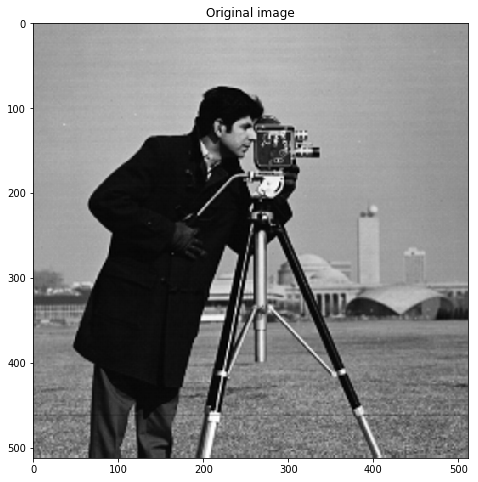

In [5]:
# load image
y0 = data.camera()
y0 = y0.astype(np.float64)

M, N = y0.shape

plt.figure(figsize=(8,8))
plt.imshow(y0, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Original image')
plt.show()

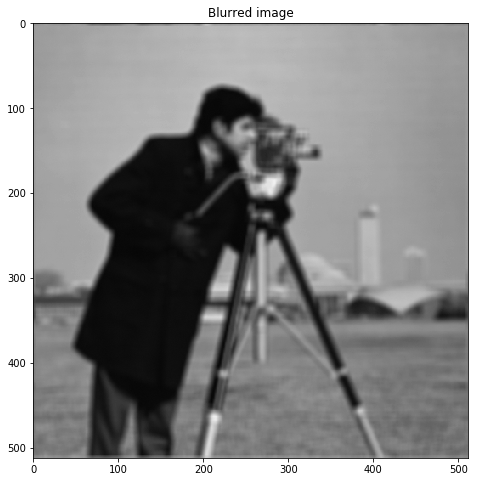

In [6]:
lh = 9

kernel = np.ones((lh, lh))
kernel = kernel/np.sum(kernel)

h = np.zeros(y0.shape)
h[0:lh, 0:lh] = kernel
h = h/h.sum()
h = np.roll(h,-int((lh-1)/2.), axis=1) # circular shift
h = np.roll(h,-int((lh-1)/2.), axis=0) # circular shift


#y = np.real(ifft2(fft2(h)*fft2(y0))) + 0.5*np.random.randn(M,N)
y = convolve2d(y0, kernel, mode='same', boundary='wrap') + 0.5*np.random.randn(M,N)


plt.figure(figsize=(8,8))
plt.imshow(y, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Blurred image')
plt.show()

In [7]:
# inverse redundant discrete wavelet transform (IRDWT)
def irdwt_TI2D(v, h_0, h_1, levels):
    scalefactor = 2
    n1, n2 = v.shape
    n = min(n1,n2)
    t1 = v[:,0:n]*scalefactor**((levels-1))
    t2 = np.zeros((n1, (levels-1)*n*3))
    for ll in range(1,levels):
        t2[:,(ll-1)*n*3:ll*n*3] = v[:,n+(ll-1)*n*3:n+ll*n*3] * scalefactor**(ll)
    return irdwt(t1, t2, h_0, h_1, levels-1)[0]
#Author: Mario Figueiredo

# redundant discrete wavelet transform (RDWT)
def rdwt_TI2D(v, h_0, h_1, levels):
    scalefactor = 2
    m, n = v.shape
    temp1, temp2, lev = rdwt(v, h_0, h_1, levels-1)
    temp1 = temp1*scalefactor**(-(levels-1))
    for ll in range(1,levels):
        temp2[:,(ll-1)*n*3:ll*n*3] = temp2[:,(ll-1)*n*3:ll*n*3]*scalefactor**(-ll);
    return np.hstack((temp1, temp2))
#Author: Mario Figueiredo

# wavelet representation
c0, c1, r0, r1 = waveletCoeffs('haar')
levels = 4

W =  lambda v: irdwt_TI2D(v, r0, r1, levels) # inverse transform
WT =  lambda v: rdwt_TI2D(v, c0, c1, levels) # forward transform

In [8]:
assert(norm(W(WT(y0)) - y0, 'fro')/norm(y0, 'fro') < 1e-8) # W^T * W = I

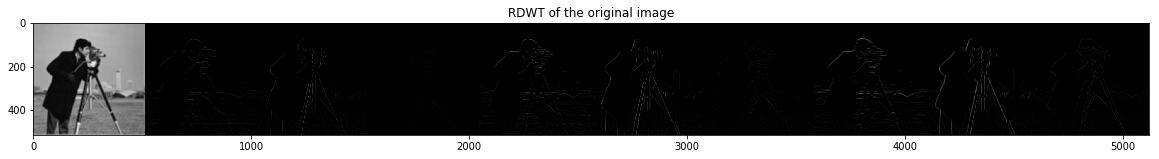

In [9]:
plt.figure(figsize=(20,10))
plt.imshow(WT(y0), cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('RDWT of the original image')
plt.show()

In [10]:
H_FFT = fft2(h)
HC_FFT = np.conj(H_FFT)

#H = lambda v: convolve2d(v, kernel, mode='same', boundary='wrap')
H =  lambda v: np.real(ifft2(H_FFT*fft2(v)))
HT = lambda v: np.real(ifft2(HC_FFT*fft2(v)))

A = lambda v: H(W(v))
AT = lambda v: WT(HT(v))

In [11]:
x = AT(y)
shape = x.shape
print(np.prod(shape))

2621440


## Synthesis formulation

${x} = \underset{{x}}{\mathrm{argmin}} \: \|{HWx} - {y}\|^2 + \lambda\|{x}\|_1$

$y_{rec} = Wx$

Accelerated Proximal-Gradient Method for Large Scale Convex Problems: http://www.yisongyue.com/courses/cs155/2015_winter/lectures/FISTA.pdf

In [18]:
def prox_l1(x, tau):
    return np.sign(x) * np.maximum(np.abs(x) - tau, 0)

In [27]:
def proximal_gradient(prox_h, grad_g, x0, beta, accelerated=True, max_iter=1000):
    """Minimize the sum of two functions using the Forward-backward splitting.
    scheme.
    This algorithm assumes that F, G is "proximable" and L has a
    L-Lipschitz gradient where the optimization objective reads::
        g(x) + h(x)
    ----------
    prox_g : callable
        should take two arguments : an ndarray and a float.
    grad_h : callable
        same as prox_g.
    x0 : ndarray
        initial guess for the solution.
    beta : float
        Module of Lipschitz of \nabla g.
    """
    fbdamping = 1.   
    gamma = fbdamping / beta
    t = 1
    x = x0.copy()
    if accelerated:
        y = x0.copy()    
    k = 1
    x_old = x*0.2 + 0.1
    while norm(x - x_old)/norm(x) > 1e-5 and k < max_iter:
        if k % 10 == 0:
            print("Iter: %4d, rel iter diff: %f" % (k, norm(x - x_old)/norm(x)))                     
        x_old = x        
        if accelerated:
            x = prox_h(y - gamma * grad_g(y), gamma)
            t_new = (1 + np.sqrt(1 + 4*t**2)) / 2
            #y = x + (t - 1) / t_new * (x - x_old)
            y = x + (k-1)/(k+2) * (x - x_old)
            t = t_new    
        else:
            x = prox_h(x - gamma * grad_g(x), gamma)            
        k = k+1            
    return x

In [14]:
from scipy.sparse.linalg import eigs
from scipy.sparse.linalg import LinearOperator

In [172]:
def mv(x):
    return AT(A(x.reshape(*shape))).flatten()

d = np.prod(shape)
L = LinearOperator((d, d), matvec=mv)

evals, evecs = eigs(L, 1)

beta = np.real(evals[0])

print(beta)

1.0000000000000004


In [15]:
def mv(x):
    return HT(H(x.reshape(N,M))).flatten()

d = N*M
L = LinearOperator((d, d), matvec=mv)

evals, evecs = eigs(L, 1)

alpha = np.real(evals[0])

print(alpha)

0.9999999999999988


In [30]:
lmbda = 0.01

grad_g = lambda x:  AT(A(x) - y)
prox_h = lambda x, gamma:  prox_l1(x, gamma*lmbda)

x0 = WT(y)

x_sol = proximal_gradient(prox_h, grad_g, x0, beta, accelerated=1, max_iter=400)

Iter:   10, rel iter diff: 0.004924
Iter:   20, rel iter diff: 0.002874
Iter:   30, rel iter diff: 0.001788
Iter:   40, rel iter diff: 0.001410
Iter:   50, rel iter diff: 0.001252
Iter:   60, rel iter diff: 0.001180
Iter:   70, rel iter diff: 0.001141
Iter:   80, rel iter diff: 0.001115
Iter:   90, rel iter diff: 0.001096
Iter:  100, rel iter diff: 0.001081
Iter:  110, rel iter diff: 0.001066
Iter:  120, rel iter diff: 0.001051
Iter:  130, rel iter diff: 0.001035
Iter:  140, rel iter diff: 0.001020
Iter:  150, rel iter diff: 0.001005
Iter:  160, rel iter diff: 0.000990
Iter:  170, rel iter diff: 0.000975
Iter:  180, rel iter diff: 0.000962
Iter:  190, rel iter diff: 0.000948
Iter:  200, rel iter diff: 0.000936
Iter:  210, rel iter diff: 0.000925
Iter:  220, rel iter diff: 0.000914
Iter:  230, rel iter diff: 0.000902
Iter:  240, rel iter diff: 0.000892
Iter:  250, rel iter diff: 0.000882
Iter:  260, rel iter diff: 0.000870
Iter:  270, rel iter diff: 0.000859
Iter:  280, rel iter diff: 0

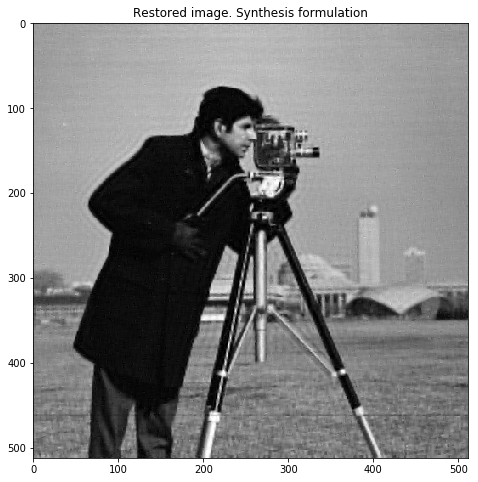

In [31]:
plt.figure(figsize=(8,8))
plt.imshow(W(x_sol), cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Restored image. Synthesis formulation')
plt.show()

In [32]:
mse = norm(y0 - W(x_sol),'fro')**2 /(M*N)
ISNR = 10.*np.log10(norm(y-y0,'fro')**2 / (mse*M*N) )

print("MSE: %0.2f, ISNR: %0.2f dB" % (mse, ISNR))

MSE: 35.08, ISNR: 8.51 dB


## Analysis formulation

$y_{rec} = \underset{{x}}{\mathrm{argmin}} \: \|{Hx} - {y}\|^2 + \lambda\|{{W}^T x}\|_1$

In [12]:
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg, lsqr
from scipy.linalg import norm

In [13]:
# Preconditioned conjugate gradient method
def pcg(A, b, x0, n_iter=None, M=None):
    if M==None:
        M = lambda v: v
    x = x0.copy()
    r = b - A(x)
    z = M(r)
    p = z
    rsold = np.sum(r*z);
    if n_iter==None:
        n_iter = np.size(b)
    for i in range(n_iter):
        Ap = A(p)
        alpha = rsold / np.sum(p*Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        z = M(r)
        rsnew = np.sum(r*z)
        if np.sqrt(rsnew) < 1e-10:
              break
        p = z + (rsnew / rsold) * p
        rsold = rsnew
    return x

In [168]:
def analysis_l1_admm(H, HT, W, WT, y, lmbda, rho=0.1, max_iter=10000):
    """Solves
    0.5*||H*x - y||^2_2 + lmbda*||W.T*x||_1
    using ADMM
    """
    x = y.copy()
    z = WT(x)
    u = z.copy()
    
    is_converged = False
    for iteration in range(max_iter):
        # update x
        A_ = lambda x: HT(H(x)) + rho*W(WT(x))
        b_ = HT(y) + W(rho*z - u)
        x = pcg(A_, b_, x, n_iter=10)
        # update z
        z = prox_l1(WT(x) + 1/rho*u, lmbda/rho)
        # update u
        r = WT(x) - z
        u = u + rho*(r)   
        # check convergence
        if norm(r)/np.max([norm(WT(x)), norm(z)]) < 1e-7:
            is_converged = True
            break
        if iteration % 10 == 0:
            print("Iter: %5d, f = %15.2f" % (iteration, 0.5*norm(H(x) - y, 'fro')**2 + lmbda*np.sum(np.abs(WT(x)))))
    if not is_converged:
        print('Warning! Convergence criterion is not satisfied!')
    return x


In [169]:
lmbda = 0.001
y_sol = analysis_l1_admm(H, HT, W, WT, y, lmbda, rho=2.0, max_iter=400)

Iter:     0, f =    258546606.94
Iter:    10, f =       515242.55
Iter:    20, f =       323245.13
Iter:    30, f =       246126.56
Iter:    40, f =       200718.14
Iter:    50, f =       170723.15
Iter:    60, f =       149679.61
Iter:    70, f =       134336.99
Iter:    80, f =       122827.15
Iter:    90, f =       113988.32
Iter:   100, f =       107061.70
Iter:   110, f =       101534.40
Iter:   120, f =        97050.88
Iter:   130, f =        93359.38
Iter:   140, f =        90278.54
Iter:   150, f =        87675.47
Iter:   160, f =        85451.35
Iter:   170, f =        83531.79
Iter:   180, f =        81859.87
Iter:   190, f =        80391.55
Iter:   200, f =        79092.41
Iter:   210, f =        77935.22
Iter:   220, f =        76898.13
Iter:   230, f =        75963.50
Iter:   240, f =        75116.90
Iter:   250, f =        74346.53
Iter:   260, f =        73642.52
Iter:   270, f =        72996.65
Iter:   280, f =        72401.97
Iter:   290, f =        71852.58
Iter:   30

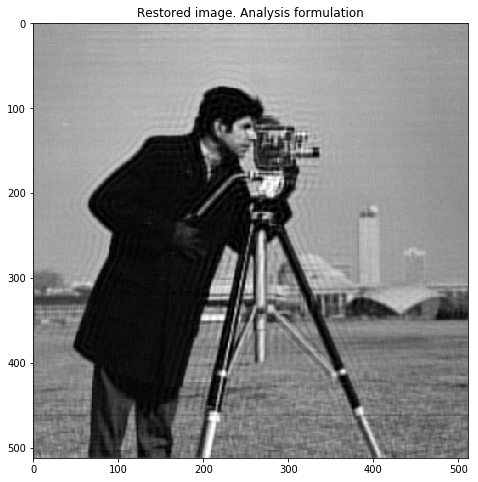

In [170]:
plt.figure(figsize=(8,8))
plt.imshow(y_sol, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Restored image. Analysis formulation')
plt.show()

In [171]:
mse = norm(y0 - y_sol,'fro')**2 /(M*N)
ISNR = 10.*np.log10(norm(y-y0,'fro')**2 / (mse*M*N) )

print("MSE: %0.2f, ISNR: %0.2f dB" % (mse, ISNR))

MSE: 53.36, ISNR: 6.68 dB


Fast dual proximal gradient algorithm: https://web.iem.technion.ac.il/images/user-files/becka/papers/40.pdf

In [19]:
def analysis_l1_FDPG(H, HT, W, WT, y, lmbda, max_iter=10000):

    u = WT(y)
    v = u.copy()
    v_old = v.copy()
    x = y.copy()
    x_old = x.copy()
    
    HTy = HT(y)
    
    L = 1/1 + 0.1
    
    t = 1.
    for k in range(max_iter):
        
        A_ = lambda x: HT(H(x))
        b_ = HTy + W(u)
        x = pcg(A_, b_, x, n_iter=10)
        
        s = prox_l1(WT(x) - L*u, L*lmbda)
        
        v = u - 1/L*(WT(x) - s)
        
        t_old = t
        t = 0.5*(1 + np.sqrt(1 + 4*t**2)) # reduces to the usual proximal gradient when t=1
        u = v + (t_old - 1)/t*(v - v_old)
               
        v_old = v
        if norm(x_old - x)/norm(x) < 1e-12:
            print("Converged in %d iterations!" % (k))
            break
        x_old = x
        if k % 10 == 0:
            print("Iter: %5d, f = %15.2f" % (k, 0.5*norm(H(x) - y, 'fro')**2 + lmbda*np.sum(np.abs(WT(x)))))
    return x

In [20]:
lmbda = 0.001
y_sol = analysis_l1_FDPG(H, HT, W, WT, y, lmbda, max_iter=200)

Iter:     0, f =   2334172100.98
Iter:    10, f =        77823.77
Iter:    20, f =        65667.25
Iter:    30, f =        61017.98
Iter:    40, f =        58544.16
Iter:    50, f =        57060.13
Iter:    60, f =        56115.36
Iter:    70, f =        55492.20
Iter:    80, f =        55069.17
Iter:    90, f =        54775.43
Iter:   100, f =        54569.00
Iter:   110, f =        54421.29
Iter:   120, f =        54314.22
Iter:   130, f =        54235.22
Iter:   140, f =        54176.09
Iter:   150, f =        54131.21
Iter:   160, f =        54096.65
Iter:   170, f =        54069.71
Iter:   180, f =        54048.48
Iter:   190, f =        54031.78


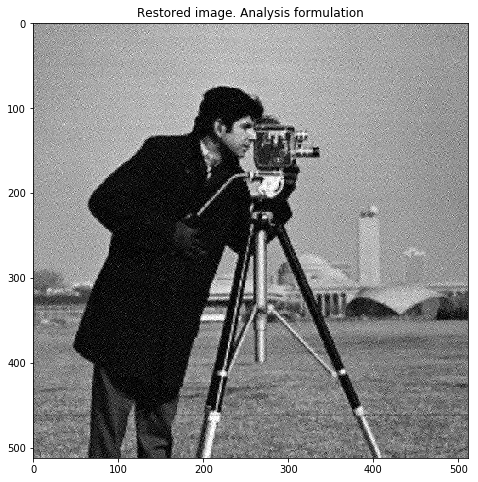

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(y_sol, cmap=plt.cm.gray, vmin=0, vmax=255)
plt.title('Restored image. Analysis formulation')
plt.show()

In [22]:
mse = norm(y0 - y_sol,'fro')**2 /(M*N)
ISNR = 10.*np.log10(norm(y-y0,'fro')**2 / (mse*M*N) )

print("MSE: %0.2f, ISNR: %0.2f dB" % (mse, ISNR))

MSE: 327.72, ISNR: -1.20 dB
